In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import IPython
import pandas as pd
import pickle

import os
os.chdir("F:\M2\Interpretable-TimeSeries-Classification")

## Importing data

In [83]:
dataloc  = "Data/genres_original/"

genres = os.listdir(dataloc)

musiclist = []
genrelist = []
srlist = []

musictrain = []
genretrain = []
srtrain = []
musictest = []
genretest = []
srtest = []

print("Reading songs")
for genre in genres:
    for i, music in enumerate(os.listdir(dataloc + genre)):
        try:
            music_time_series, sr = librosa.load(dataloc + genre + "/" + music)
            music_time_series = librosa.effects.preemphasis(music_time_series)
        except Exception as e:
            print(f"Error loading {music}: {e}")
            continue
        srlist.append(sr)
        musiclist.append(music_time_series)
        genrelist.append(genre)

        if i<25: # 25-75 test train split
            musictest.append(music_time_series)
            genretest.append(genre)
            srtest.append(sr)
        else:
            musictrain.append(music_time_series)
            genretrain.append(genre)
            srtrain.append(sr)

print("Creating dataframe")
fulldata = pd.DataFrame({'Music': musiclist, 'Genre': genrelist, "SampleRate": srlist})

print("Saving dataframe")
fulldata.to_csv("Data/fulldata.csv", index=False)

print("Saving train and test data")
train = pd.DataFrame({"Music" : musictrain, "Genre" : genretrain, "SampleRate": srtrain})
test = pd.DataFrame({"Music" : musictest, "Genre" : genretest, "SampleRate": srtest})

with open("Data/train.pkl", "wb") as f:
    pickle.dump(train, f)

with open("Data/test.pkl", "wb") as f:
    pickle.dump(test, f)

Reading songs


C:\Users\melvi\AppData\Local\Temp\ipykernel_14652\4229736660.py:20: UserWarning: PySoundFile failed. Trying audioread instead.
  music_time_series, sr = librosa.load(dataloc + genre + "/" + music)
C:\Users\melvi\AppData\Roaming\Python\Python39\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading jazz.00054.wav: 
Creating dataframe
Saving dataframe
Saving train and test data


In [2]:
with open("Data/train.pkl", "rb") as f:
    train = pickle.load(f)

with open("Data/test.pkl", "rb") as f:
    test = pickle.load(f)

## SAX Implementation

In [3]:
alphabet = np.array(["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"])

def SAX(time_series, w, alpha):
    time_series = np.array(time_series)
    time_series = (time_series - np.mean(time_series)) / np.std(time_series)

    # PAA
    PAA=[]
    for word_index in range(w):
        ceiling = min(len(time_series), int((word_index+1)*len(time_series)/w))
        PAA.append(np.mean(time_series[int(word_index*len(time_series)/w):ceiling]))
    
    lookup = np.quantile(time_series, np.arange(1,alpha)*(1/alpha) )
    
    sax = np.digitize(PAA, lookup)

    return list(sax)

def SAX_window(time_series, w, alpha, l):
    L = len(time_series)
    sax_sentence = []
    previous_word = np.full(w,-1)

    for i in range(0, (L-l+1), l//2):
        ceiling = min(L, (i+1)*l)
        sax_word = SAX(time_series[i : ceiling], w, alpha)

        npsaxword = np.array(sax_word)
        if np.sum(npsaxword - previous_word) == 0: # Remove repeated words for reasons
            continue
        
        if i > 0:
            sax_sentence.append(" ")
        sax_sentence.extend(sax_word)
        previous_word = sax_word

    phrase = ""
    for letter in sax_sentence:
        if isinstance(letter, np.int64):
            phrase += alphabet[letter]
        else :
            phrase += letter
    return phrase

In [61]:
# Tried a parallelized version for increment 1, gets OOM
"""def SAX_window(time_series, w, alpha, l):
    L = len(time_series)
    sax_sentence = []
    previous_word = np.full(w,-1)

    all_windows= np.empty((l,L - l + 1))
    for i in range(0, L-l+1):
        print(i)
        ceiling = i+l
        all_windows[i] = time_series[i : ceiling]

    allsax = np.apply_along_axis(SAX, 0, all_windows)
    print(allsax.shape)

    phrase = ""
    for letter in sax_sentence:
        if isinstance(letter, np.int64):
            phrase += alphabet[letter]
        else :
            phrase += letter
    return phrase"""

In [89]:
nptrainmusic = train["Music"].to_numpy()

selected_index = 81
selected_music = nptrainmusic[selected_index]

# Pre-process eliminating noise
#testmusic = librosa.effects.preemphasis(testmusic)

sentence = SAX_window(selected_music, w = 16, alpha = 4, l = int(.2*len(selected_music)+1 ))
print(sentence)

ccccbccccccbcbcb cccccccccccccccc cccccccbcccccccc cccccccccccccccc cbcccccccccccccc cccccccccccccbbb


## SFA Implementation

In [20]:
alpha = 4
w , halfw= 4, 2

DFT_base_length4 = np.empty((len(nptrainmusic), w))

for i, music in enumerate(nptrainmusic):
    fft = np.fft.fft(music)
    halfw_real = np.real(fft[:halfw])
    halfw_complex = np.imag(fft[:halfw])
    
    DFT_base_length4[i] = np.array([halfw_real[0], halfw_complex[0], halfw_real[1], halfw_complex[1]]) # Shitty inefficient, can be made with np.apply_along_axis

q =  np.arange(1,alpha)*(1/alpha)

SFA_breakpoints = np.quantile(DFT_base_length4, q, axis=0)


In [4]:
def SFA(time_series, alpha=alpha, w=w, lookup=SFA_breakpoints):
    fft = np.fft.fft(time_series)
    halfw = w//2
    halfw_real = np.real(fft[:halfw])
    halfw_complex = np.imag(fft[:halfw])
    coefs = np.array([halfw_real[0], halfw_complex[0], halfw_real[1], halfw_complex[1]])

    sfa=np.empty(w, dtype=np.int64)
    for i, coef in enumerate(coefs):
        sfa[i] = np.digitize(coef, lookup[:,i]) * (i+1) # *(i+1) to make sure same indices for different coefficients don't get the same symbol

    return sfa

def SFA_window(time_series, l, alpha=alpha, w=w, lookup=SFA_breakpoints):
    L = len(time_series)
    sfa_sentence = []
    previous_word = np.full(w,-1)

    for i in range(0, L, l): # Non-overlapping windows for this one
        ceiling = min(L, (i+1)*l) 
        sfa_word = SFA(time_series[i : ceiling], w, alpha, lookup=lookup)

        npsfaword = np.array(sfa_word)
        if np.sum(npsfaword - previous_word) == 0: # Remove repeated words for reasons
            continue
        
        if i > 0:
            sfa_sentence.append(" ")
        sfa_sentence.extend(sfa_word)
        previous_word = sfa_word

    phrase = ""
    for letter in sfa_sentence:
        if isinstance(letter, np.int64):
            phrase += alphabet[letter]
        elif letter == " ":
            phrase += letter
        else:
            raise ValueError("error, got letter", letter)
    return phrase

NameError: name 'alpha' is not defined

In [82]:
selected_index = 162
selected_music = nptrainmusic[selected_index]

print(SFA_window(selected_music, l=int(.2*len(selected_music+1))))

dagi dgdi dagi dedi dede dege


## SEQL

In [262]:
class SEQL:
    def __init__(self, C=1.0, alpha=0.5, convergence_threshold=1e-5, max_iterations=1000):
        self.C = C
        self.alpha = alpha
        self.convergence_threshold = convergence_threshold
        self.max_iterations = max_iterations
        self.beta = None
        self.best_feature = None
        self.index_to_feature = []
        self.bigX = []

    def _compute_regularization_gradient(self, beta):
        """Elastic-net gradient."""
        return self.alpha * np.sign(beta) + (1 - self.alpha) * beta

    def _compute_loss_gradient(self, X, y, beta):
        """Compute gradients for all features."""
        margins = y * (X @ beta)
        probabilities = -1 / (1 + np.exp(np.clip(margins, -500, 500)))
        gradients = X.T @ (y * probabilities) / len(y)
        return gradients
    
    def _line_search(self, X, y, beta, gradients, best_gradient_index, verbose = False):
        """Perform a line search to find the optimal step size for updating beta."""
        old_margins = y * (X @ beta)
        old_loss = np.mean(np.log(1 + np.exp(-old_margins))) + self.C * (
            self.alpha * np.sum(np.abs(beta)) + (1 - self.alpha) * 0.5 * np.sum(beta ** 2)
        )

        step_size = 10
        while step_size > 1e-10:
            new_beta = beta.copy()
            new_beta[best_gradient_index] -= step_size * gradients[best_gradient_index]
            new_margins = y * (X @ new_beta)
            new_loss = np.mean(np.log(1 + np.exp(-new_margins))) + self.C * (
                self.alpha * np.sum(np.abs(new_beta)) + (1 - self.alpha) * 0.5 * np.sum(new_beta ** 2)
            )
            
            if new_loss < old_loss :
                return step_size
            step_size *= 0.8
        
        if verbose : print("Failed line search")
        return 1e-10  # Return a small constant to prevent zero step size
    


    def fit(self, representations, y, nb_classes = False, plot_grads = False, verbose = False):
        """
        representations : symbolic representations of the whole training set using the same discretization method and parameters
        y : labels to predict
        """
        representations = np.array(representations)

        if not nb_classes:
            nb_classes = max(y)+1
        y_one_hot = np.zeros((len(y), nb_classes))
        y_one_hot[np.arange(len(y)), y] = 1

        # Extract unigrams from the representations
        feature_map = {char: idx for idx, char in enumerate(set(''.join(representations).replace(' ', '')))} # initialize unigrams and their ID
        map_features = [char for char in feature_map.keys()]
        nb_new_features = len(feature_map)

        # Initialize feature matrix
        X = np.zeros((len(representations), len(feature_map)))

        # Build initial feature matrix
        for i, seq in enumerate(representations):
            for feature in feature_map:
                X[i, feature_map[feature]] = seq.count(feature)

        num_features = X.shape[1]
        self.beta = np.zeros(num_features)

        if plot_grads: best_grads=[]

        for iteration in range(self.max_iterations):
            #Compute gradients
            loss_gradients = self._compute_loss_gradient(X, y, self.beta) 
            regu_gradients = self._compute_regularization_gradient(self.beta) * self.C
            gradients = loss_gradients + regu_gradients

            best_gradient = np.max(abs(gradients))
            best_gradient_index = np.argmax(abs(gradients))
            if plot_grads : best_grads.append(best_gradient)

            if np.sum(X[:, best_gradient_index]) == 0: #If the feature is not present in the dataset
                print("Problem at iteration", iteration)
                print("Best gradient :", best_gradient)
                print("Sum gradients :", gradients.sum()) 
                raise ValueError("Best feature not present in dataset")

            if verbose : print("Iteration",iteration,", best gradient :", best_gradient)

            #Stopping condition
            if best_gradient < self.convergence_threshold :
                break

            #Expand features
            new_features = set()

            for feature_idx in range(num_features-1, num_features- nb_new_features-1, -1): #Only extend features added during last iteration
                subseq = map_features[feature_idx]
                for seq in representations[X[:,feature_idx] > 0]: #Only consider sequences where the feature is present
                    found = seq.find(subseq)
                    while found>=0:
                        if found + len(subseq) + 1 >= len(seq): #Don't cross over the end of the sequence
                            break

                        newchar = seq[found + len(subseq) + 1]
                        if newchar != ' ': #Don't cross over several words
                            new_features.add(subseq+newchar)

                        found = seq.find(subseq, found+1)
                        
            if verbose : print("Number of new features:", len(new_features))

            #Prune
            upper_bounds = []
            checked_prefixes = [False] * len(feature_map)
            for new_feature in new_features:
                prefix_index = feature_map[new_feature[:-1]]

                if checked_prefixes[prefix_index]:
                    upper_bounds.append(checked_prefixes[prefix_index])
                    continue

                prefix_appearances = X[:, prefix_index] > 1e-10 #indices where the prefix is present
                
                boundmax = 0
                for classe in [-1,1]:
                    check_indices = (prefix_appearances * y==classe)
                    bound = np.sum((-classe * 1/(1+np.exp(np.clip(classe * X[check_indices, :] @ self.beta, -500, 500))))) 
                    bound+= regu_gradients[prefix_index]
                    bound = abs(bound)
                    if bound > boundmax:
                        boundmax = bound

                upper_bounds.append(boundmax)
                checked_prefixes[prefix_index] = boundmax
            
            prune = upper_bounds <= best_gradient
            nb_new_features = len(new_features) - np.sum(prune)

            for i,feature in enumerate(new_features):
                if prune[i]: continue
                map_features.append(feature)
                feature_map[feature] = len(feature_map)

            num_features = len(feature_map)
            new_X = np.zeros((len(representations), nb_new_features)) # There is a way to do feature expansion, pruning and X update all within the same loop, do later
            X = np.block([X, new_X])
            
            nb_previous_features = num_features - nb_new_features
            for i, seq in enumerate(representations):
                nonpruned=0
                for j, feature in enumerate(new_features):
                    if prune[j]: continue
                    X[i, nb_previous_features+nonpruned ] = seq.count(feature)
                    nonpruned+=1
            
            self.beta = np.append(self.beta, np.zeros(nb_new_features)) # Add 0 coefs to new features
            step_size = self._line_search(X, y, self.beta, gradients, best_gradient_index, verbose=verbose) 
            self.beta[best_gradient_index] -= step_size * gradients[best_gradient_index] # Update beta

            if verbose : 
                print("Number of features after pruning:", X.shape[1],",",np.sum(prune),"features pruned")
                print("Gradient Upper bounds :", upper_bounds)

        #Append selected features to selected features list
        self.index_to_feature.extend(map_features)
        
        if not len(self.bigX):
            self.bigX = X
        else :
            self.bigX = np.block([self.bigX, X])

        if plot_grads:
            plt.title("Best gradient per iteration")
            plt.xlabel("Iteration")
            plt.ylabel("Best gradient")
            plt.plot(best_grads)
            plt.grid('yes')
            plt.show()
        
        print(f"Finished training after {iteration} iterations, last best gradient : {best_gradient}")

    def predict(self, representations, selected_features_indices = []):
        # Build feature matrix
        if len(selected_features_indices):
            selected_features = np.array(self.index_to_feature)[selected_features_indices]
        else :
            selected_features = np.array(self.index_to_feature)

        X = np.zeros((len(representations), len(selected_features)))
        for i, seq in enumerate(representations):
            for j, feature in enumerate(selected_features):
                X[i, j] = seq.count(feature)

        return np.sign(X @ self.beta)
    
    def predict_probas(self, representations, selected_features_indices = []):
         # Build feature matrix
        if len(selected_features_indices):
            selected_features = np.array(self.index_to_feature)[selected_features_indices]
        else :
            selected_features = np.array(self.index_to_feature)

        X = np.zeros((len(representations), len(selected_features)))
        for i, seq in enumerate(representations):
            for j, feature in enumerate(selected_features):
                X[i, j] = seq.count(feature)

        return X @ self.beta
    
    def accuracy(self, representations, y, selected_features_indices = []):
        return np.mean(self.predict(representations, selected_features_indices) == y)
            

## Cancer

In [413]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data

y = data.target
# Convert labels from {0, 1} to {-1, 1}
y = 2 * y - 1

# Split the dataset into training and testing sets
X_train, X_test, y_cancer_train, y_cancer_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)
print("First 5 labels:", y[:5])

cancer_sax = np.array([SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in X_train])
cancer_sax_test = np.array([SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in X_test])

Dataset shape: (569, 30)
Labels shape: (569,)
First 5 labels: [-1 -1 -1 -1 -1]


c:\ProgramData\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Iteration 0 , best gradient : 6.097417840375587
Number of new features: 16
Number of features after pruning: 20 , 0 features pruned
Gradient Upper bounds : [134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0]
Iteration 1 , best gradient : 5.587343156458466
Number of new features: 64
Number of features after pruning: 84 , 0 features pruned
Gradient Upper bounds : [116.18886738501186, 54.47725516817813, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 114.71544782247895, 54.47725516817813, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 116.18886738501186, 114.71544782247895, 116.188867385011

C:\Users\melvi\AppData\Local\Temp\ipykernel_14652\2165484578.py:35: RuntimeWarning: overflow encountered in exp
  new_loss = np.mean(np.log(1 + np.exp(-new_margins))) + self.C * (


Number of new features: 307
Number of features after pruning: 524 , 63 features pruned
Gradient Upper bounds : [30.89107650250773, 106.85979733284785, 110.44801327670203, 113.30680136872914, 107.6077953004813, 33.78582001087531, 98.96845964909137, 15.763945386725217, 17.952886661732833, 57.60750569378456, 58.79016113448164, 2.0868667585187515, 1.7453275796273782, 3.7495824663627935, 74.18889367191646, 110.4665833925084, 30.633892441758782, 53.05778453059335, 17.952886661732833, 14.232793117322206, 73.82456017030597, 3.764494803912863, 15.763945386725217, 58.79016113448164, 36.5050497477234, 51.687452981888526, 60.91575167870938, 1.459731176188383, 60.91575167870938, 0.2816028720347041, 58.79016113448164, 113.30680136872914, 33.39290829469858, 53.05778453059335, 12.888463920808155, 64.80342667979443, 4.876105872217601, 4.046097675947566, 21.56009856380246, 14.184535696717274, 30.89107650250773, 113.30680136872914, 106.85979733284785, 0.8780672340285823, 7.627421215673849, 99.76085887622

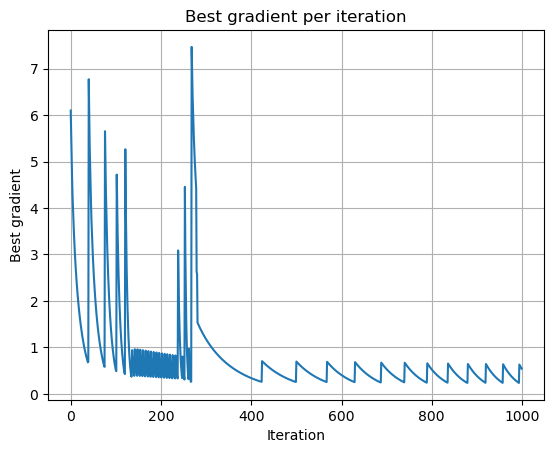

Finished training after 999 iterations, last best gradient : 0.542219806893471
Train accuracy: 0.8615023474178404
Test accuracy: 0.8881118881118881


In [327]:
seql = SEQL(convergence_threshold=.002, max_iterations=1000, C=0)
seql.fit(cancer_sax, y_cancer_train, plot_grads=True, verbose =True)

print("Train accuracy:", seql.accuracy(cancer_sax, y_cancer_train))
print("Test accuracy:", seql.accuracy(cancer_sax_test, y_cancer_test))

Predicted label: [1.]
True label: 1


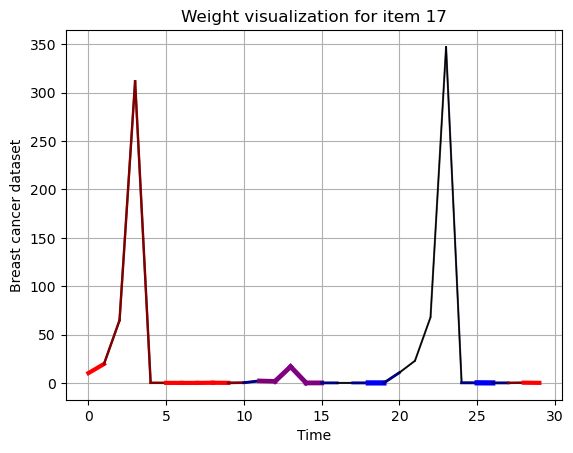

In [414]:
def interpret(model, timeseriesdata, saxdata, ydata, index, custom_ylabel=False):
    ts = timeseriesdata[index]
    saxed = saxdata[index]
    label = ydata[index]

    important_subseq_indices = np.where(abs(model.beta) > 1e-5)[0]
    important_subseqs = np.array(model.index_to_feature)[important_subseq_indices]

    highlights = np.zeros(len(ts))
    for i, subseq in enumerate(important_subseqs):
        start = saxed.find(subseq)
        while start >= 0:
            end = start + len(subseq)
            highlights[start:end] += model.beta[important_subseq_indices[i]] / len(subseq)
            start = saxed.find(subseq, end)

    # Normalize highlights to be between 0 and 1
    positive_highlights = np.maximum(0,highlights)
    negative_highlights = np.maximum(0,-highlights)

    highlights /= np.max(np.abs(highlights))

    redhue= (positive_highlights - np.min(positive_highlights)) / (np.max(positive_highlights) - np.min(positive_highlights))
    bluehue = (negative_highlights - np.min(negative_highlights)) / (np.max(negative_highlights) - np.min(negative_highlights))
    hues = np.stack([redhue, np.zeros(len(ts)), bluehue], axis=-1)

    print("Predicted label:", model.predict([saxed]))
    print("True label:", label)

    plt.title("Weight visualization for item " + str(index))
    plt.grid('a')
    plt.xlabel("Time")
    if custom_ylabel: plt.ylabel(custom_ylabel)
    plt.plot(ts, color="black", alpha=.6)
    for i in range(len(ts)-1):
        plt.plot([i,i+1], ts[i : i+2], color=(hues[i] + hues[i+1])/2, lw = 2**(abs(highlights[i]) + abs(highlights[i+1])) )
    plt.show()

interpret(seql, X_test, cancer_sax_test, y_cancer_test, 17, custom_ylabel="Breast cancer dataset")

In [ ]:
from sktime.datasets import load_UCR_UEA_dataset
print("Loading data...")
# Load the ItalyPowerDemand dataset
X_train, y_train = load_UCR_UEA_dataset(name="ItalyPowerDemand", split="train")
X_test, y_test = load_UCR_UEA_dataset(name="ItalyPowerDemand", split="test")

y_train, y_test = y_train.astype(int), y_test.astype(int)
y_train[y_train == 2] = -1
y_test[y_test == 2] = -1

italy_sax_train = np.array([SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in X_train])
italy_sax_test = np.array([SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in X_test])

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Loading data...
dim_0


AttributeError: 'str' object has no attribute 'values'

## Music

In [84]:
train_sax = np.array([SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in train['Music']])
train_labels = np.array(train['Genre'])

genres = np.unique(train_labels)
genre_to_index = {genre : index for index, genre in enumerate(genres)}

train_labels = np.array([genre_to_index[label] for label in train_labels])

test_sax = np.array([SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in test['Music']])
test_labels = np.array(test['Genre'])

test_labels = np.array([genre_to_index[label] for label in test_labels])

In [85]:
two_genres = ["rock", "classical"]
two_genres_index = [genre_to_index[genre] for genre in two_genres]

binary_train_indices = ((train_labels == two_genres_index[0]).astype(int) + (train_labels == two_genres_index[1]).astype(int)).astype(bool)
binary_test_indices = ((test_labels == two_genres_index[0]).astype(int) + (test_labels == two_genres_index[1]).astype(int)).astype(bool)

binary_train_sax = train_sax[train_labels == binary_train_indices]
binary_train_labels = train_labels[train_labels == binary_train_indices]

binary_test_sax = test_sax[test_labels == binary_test_indices]
binary_test_labels = test_labels[test_labels == binary_test_indices]

#Change labels to -1, 1
binary_train_labels[binary_train_labels == two_genres_index[0]] = -1
binary_train_labels[binary_train_labels == two_genres_index[1]] = 1
binary_test_labels[binary_test_labels == two_genres_index[0]] = -1
binary_test_labels[binary_test_labels == two_genres_index[1]] = 1

#Shuffle train data
shuffle = np.random.permutation(len(binary_train_sax))
binary_train_sax = binary_train_sax[shuffle]
binary_train_labels = binary_train_labels[shuffle]


binary_test_ts = test['Music'][test_labels == binary_test_indices]

In [86]:
melomane = SEQL(convergence_threshold=.002, max_iterations=10000, C=0)
melomane.fit(binary_train_sax,binary_train_labels, verbose=True)

Iteration 0 , best gradient : 9.29
Number of new features: 4
Number of features after pruning: 6 , 0 features pruned
Gradient Upper bounds : [37.0, 34.0, 34.0, 37.0]
Iteration 1 , best gradient : 0.05335241580412998
Number of new features: 8
Number of features after pruning: 8 , 6 features pruned
Gradient Upper bounds : [7.874315095440124e-13, 0.5000923345354016, 1.5749357396379952e-12, 9.233453540158337e-05, 1.5749357396379952e-12, 0.5000923345354016, 9.233453540158337e-05, 7.874315095440124e-13]
Iteration 2 , best gradient : 0.03186179731995754
Number of new features: 4
Number of features after pruning: 10 , 2 features pruned
Gradient Upper bounds : [0.2986877892230114, 1.9800735623334385e-13, 0.2986877892230114, 1.9800735623334385e-13]
Iteration 3 , best gradient : 0.021727634087126458
Number of new features: 4
Number of features after pruning: 12 , 2 features pruned
Gradient Upper bounds : [0.20369040187381154, 0.20369040187381154, 7.088310679125161e-14, 7.088310679125161e-14]
Iter

Train accuracy : 0.5
Train accuracy : 0.5
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


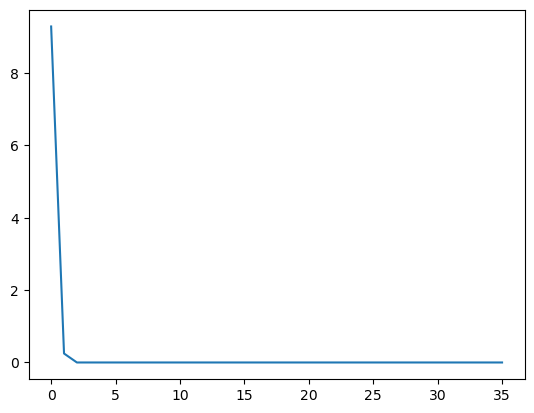

In [87]:
print("Train accuracy :",melomane.accuracy(binary_train_sax, binary_train_labels))
print("Train accuracy :",melomane.accuracy(binary_test_sax, binary_test_labels))

print(melomane.predict(binary_test_sax))
plt.plot(melomane.beta)

In [416]:
from tslearn.datasets import UCR_UEA_datasets

# Initialize the UCR_UEA_datasets object
ucr = UCR_UEA_datasets()

# Load the GunPoint dataset
X_train, y_train, X_test, y_test = ucr.load_dataset("GunPoint")

# Convert labels from {1, 2} to {-1, 1}
y_train[y_train == 2] = -1
y_test[y_test == 2] = -1

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

gunpoint_sax_train = np.array([SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in X_train])
gunpoint_sax_test = np.array([SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in X_test])

Training data shape: (50, 150, 1)
Training labels shape: (50,)
Test data shape: (150, 150, 1)
Test labels shape: (150,)


C:\Users\melvi\AppData\Local\Temp\ipykernel_14652\2165484578.py:35: RuntimeWarning: overflow encountered in exp
  new_loss = np.mean(np.log(1 + np.exp(-new_margins))) + self.C * (


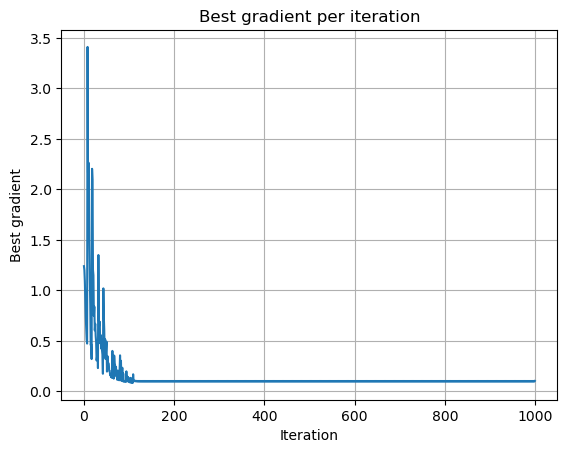

Finished training after 999 iterations, last best gradient : 0.10272763586245826
Train accuracy : 0.86
Test accuracy : 0.76


In [424]:
gunner = SEQL(convergence_threshold=.002, max_iterations=1000, C=0.2)
gunner.fit(gunpoint_sax_train, y_train, plot_grads=True)

print("Train accuracy :", gunner.accuracy(gunpoint_sax_train, y_train))
print("Test accuracy :", gunner.accuracy(gunpoint_sax_test, y_test))

Predicted label: [1.]
True label: 1


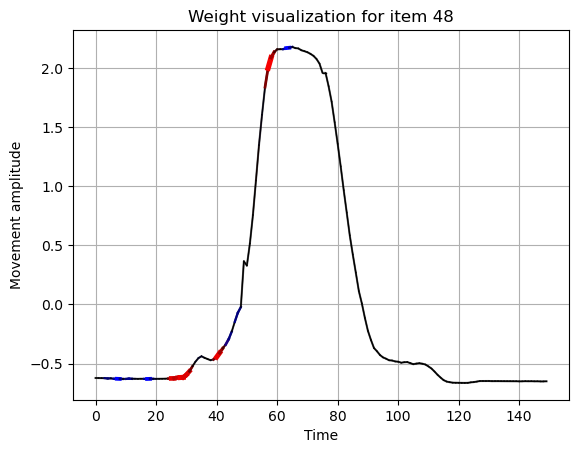

In [430]:
interpret(gunner, X_test, gunpoint_sax_test, y_test, 48, custom_ylabel="Movement amplitude")

## TP1 Data

In [113]:
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

In [233]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)


X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

In [234]:
step_train_sax = [SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in X_train]
step_test_sax = [SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in X_test]

y_train = 2 * np.array(y_train) -1
y_test = 2 * np.array(y_test) -1

c:\ProgramData\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


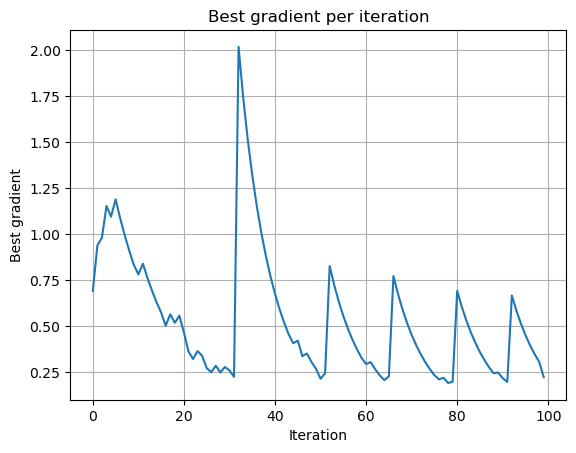

Finished training after 99 iterations, last best gradient : 0.2220265711628125
Train accuracy : 0.5833333333333334
Test accuracy : 0.3522727272727273


In [245]:
doctor = SEQL(convergence_threshold=.002, max_iterations=100, C=0)
doctor.fit(step_train_sax, y_train, plot_grads=True)

print("Train accuracy :", doctor.accuracy(step_train_sax, y_train))
print("Test accuracy :", doctor.accuracy(step_test_sax, y_test))

important_subseq_indices = np.where(abs(doctor.beta) > 1e-5)[0]
important_X = doctor.bigX[:,important_subseq_indices]

In [236]:
print(np.mean(y_train==1))
print(np.mean(y_test==1))

0.47619047619047616
0.8295454545454546


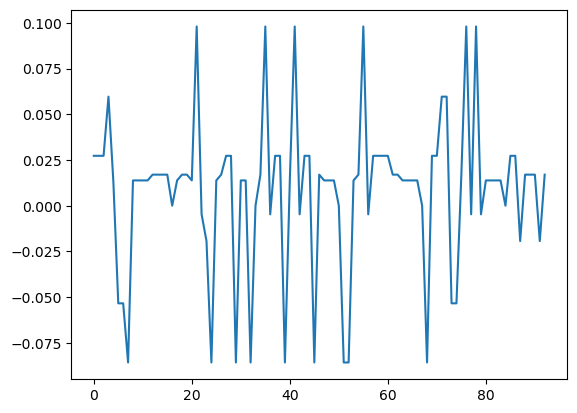

Predicted label: [1.]
True label: -1


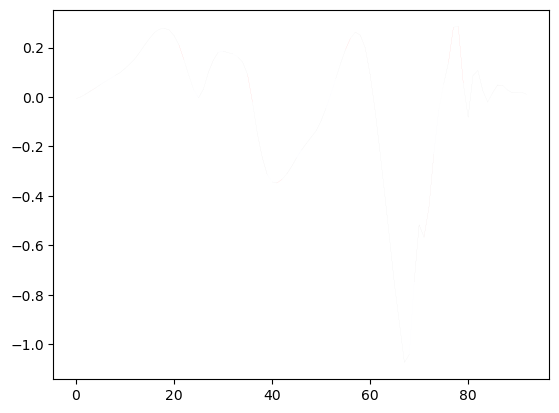

In [240]:
important_subseq_indices = np.where(abs(doctor.beta) > 1e-5)[0]
important_subseqs = np.array(doctor.index_to_feature)[important_subseq_indices]

select_index = 7
ts = X_test[select_index]
saxed = step_test_sax[select_index]

highlights = np.zeros(len(ts))
for i, subseq in enumerate(important_subseqs):
    start = saxed.find(subseq)
    while start >= 0:
        end = start + len(subseq)
        highlights[start:end] += doctor.beta[important_subseq_indices[i]] / len(subseq)
        start = saxed.find(subseq, end)

redhue= np.maximum(0, highlights) / np.max(highlights)
bluehue = np.maximum(0, -highlights) / np.max(-highlights)

plt.plot(highlights)
plt.show()


print("Predicted label:", doctor.predict([saxed]))
print("True label:", y_cancer_test[select_index])
#plt.plot(ts, color="green", alpha=.3)
for i in range(len(ts)-1):
    plt.plot([i,i+1], ts[i : i+2], color=(redhue[i], 0, bluehue[i]), lw = (highlights[i]+.4)**5)

## Logistic Regression

In [187]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Loss function (binary cross-entropy)
def compute_loss(y, y_hat):
    m = y.shape[0]
    loss = -1/m * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return loss

# Gradient descent function
def gradient_descent(X, y, weights, bias, learning_rate, iterations):
    m = X.shape[0]
    for i in range(iterations):
        # Forward propagation
        z = np.dot(X, weights) + bias
        y_hat = sigmoid(z)
        
        # Compute gradients
        dw = 1/m * np.dot(X.T, (y_hat - y))
        db = 1/m * np.sum(y_hat - y)
        
        # Update weights and bias
        weights -= learning_rate * dw
        bias -= learning_rate * db
        
        # Compute and print the loss every 100 iterations
        if i % 100 == 0:
            loss = compute_loss(y, y_hat)
            print(f"Iteration {i}, Loss: {loss}")
    
    return weights, bias

# Predict function
def predict(X, weights, bias):
    z = np.dot(X, weights) + bias
    y_hat = sigmoid(z)
    return np.round(y_hat)


# Initialize weights and bias
weights = np.zeros(important_X.shape[1])
bias = 0

# Train the model
learning_rate = 0.01
iterations = 1000
weights, bias = gradient_descent(important_X, np.array(y_train), weights, bias, learning_rate, iterations)

Iteration 0, Loss: 0.6931471805599453
Iteration 100, Loss: 1.683604326486987
Iteration 200, Loss: 1.9931629312853594
Iteration 300, Loss: 2.3373106010206093
Iteration 400, Loss: 2.4232543529457007
Iteration 500, Loss: 2.2918893462136505
Iteration 600, Loss: 2.16210693900713
Iteration 700, Loss: 2.0423451755139577
Iteration 800, Loss: 1.8899973034324087
Iteration 900, Loss: 1.720172201050972
